Dependence on primary cosmic ray flux
-----------------------------------

In [1]:
#basic imports and ipython setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
os.chdir('..')

#import solver related modules
from MCEq.core import MCEqRun
from mceq_config import config
#import primary model choices
import CRFluxModels as pm

Create an instance of an MCEqRun class. Most of its areguments are contained in the `config` dictionary from the `mceq_config` module. Look into or edit `mceq_config.py`.

If the initialization succeeds it will print out some information according to the debug level. 

In [2]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3_rc3b',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.Thunman,None),#(pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0,
#expand the rest of the options from mceq_config.py
**config
)


Hadrons:

"p-bar", "p", "n-bar", "n", "pi+", "pi-", "K0L", "K+", 
"K-"

Mixed:

"Lambda0-bar", "Lambda0", "Xi0-bar", "Xi0", "K0S", "Xi--bar", "Xi-", "Sigma--bar", 
"Sigma-", "Sigma+-bar", "Sigma+", "Omega--bar", "Omega-", "D+", "D-", "Ds+", 
"Ds-", "D0", "D0-bar", "XiC+-bar", "XiC+", "tau+", "tau-", "LambdaC+-bar", 
"LambdaC+", "XiC0-bar", "XiC0", "OmegaC0-bar", "OmegaC0", "pi0"

Resonances:

"eta", "Sigma0-bar", "Sigma0", "D*+", "D*-", "eta*", "jpsi", "phi", 
"SigmaC0-bar", "SigmaC0", "SigmaC+-bar", "SigmaC+", "SigmaC++-bar", "SigmaC++", "omega", "Xi*0-bar", 
"Xi*0", "Xi*--bar", "Xi*-", "SigmaC*0-bar", "SigmaC*0", "SigmaC*++-bar", "SigmaC*++", "SigmaC*+-bar", 
"SigmaC*+", "K*0", "K*0-bar", "K*+", "K*-", "Sigma*+-bar", "Sigma*+", "Sigma*0-bar", 
"Sigma*0", "Sigma*--bar", "Sigma*-", "etaC", "rho+", "rho-", "rho0", "Delta--bar", 
"Delta0-bar", "Delta+-bar", "Delta++-bar", "Delta++", "Delta+", "Delta0", "Delta-", "D*0", 
"D*0-bar", "XiC*0-bar", "XiC*+-bar", "XiC*+", "XiC*0", "Ds*+", "Ds*

Solve and store results
----------------------

In [3]:
#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

#Power of energy to scale the flux
mag = 3

#obtain energy grid (nver changes) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

p_spectrum_flux = []

#Initialize empty grid
for  pmcount, pmodel in enumerate([(pm.HillasGaisser2012,'H3a'),
                                   (pm.HillasGaisser2012,'H4a'),
                                   (pm.GaisserStanevTilav,'3-gen'),
                                   (pm.GaisserStanevTilav,'4-gen')]):
    
    mceq_run.set_primary_model(*pmodel)
    
    flux = {}
    for frac in ['mu_conv','mu_pr','mu_total',
                 'numu_conv','numu_pr','numu_total',
                 'nue_conv','nue_pr','nue_total','nutau_pr']:
        flux[frac] = np.zeros_like(e_grid)
        

    #Sum fluxes, calculated for different angles
    for theta in angles:
        mceq_run.set_theta_deg(theta)
        mceq_run.solve()
        #_conv means conventional (mostly pions and kaons)
        flux['mu_conv'] += (mceq_run.get_solution('conv_mu+', mag)
                           + mceq_run.get_solution('conv_mu-', mag))

        # _pr means prompt (the mother of the muon had a critical energy
        # higher than a D meson. Includes all charm and direct resonance
        # contribution)
        flux['mu_pr'] += (mceq_run.get_solution('pr_mu+', mag)
                         + mceq_run.get_solution('pr_mu-', mag))

        # total means conventional + prompt
        flux['mu_total'] += (mceq_run.get_solution('total_mu+', mag)
                            + mceq_run.get_solution('total_mu-', mag))

        # same meaning of prefixes for muon neutrinos as for muons
        flux['numu_conv'] += (mceq_run.get_solution('conv_numu', mag)
                             + mceq_run.get_solution('conv_antinumu', mag))

        flux['numu_pr'] += (mceq_run.get_solution('pr_numu', mag)
                           + mceq_run.get_solution('pr_antinumu', mag))

        flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                              + mceq_run.get_solution('total_antinumu', mag))

        # same meaning of prefixes for electron neutrinos as for muons
        flux['nue_conv'] += (mceq_run.get_solution('conv_nue', mag)
                            + mceq_run.get_solution('conv_antinue', mag))

        flux['nue_pr'] += (mceq_run.get_solution('pr_nue', mag)
                          + mceq_run.get_solution('pr_antinue', mag))

        flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                             + mceq_run.get_solution('total_antinue', mag))


        # since there are no conventional tau neutrinos, prompt=total
        flux['nutau_pr'] += (mceq_run.get_solution('total_nutau', mag)
                            + mceq_run.get_solution('total_antinutau', mag))

    #average the results
    for frac in ['mu_conv','mu_pr','mu_total',
                 'numu_conv','numu_pr','numu_total',
                 'nue_conv','nue_pr','nue_total','nutau_pr']:
        flux[frac] = flux[frac]/float(len(angles))
        
    p_spectrum_flux.append((flux,mceq_run.pmodel.sname,mceq_run.pmodel.name)) 

MCEqRun::set_primary_model():  HillasGaisser2012 H3a
MCEqRun::set_theta_deg():  0.0
Theta selection correponds to cached value, skipping calc.
MCEqRun::_calculate_integration_path():
MCEqRun::_forward_euler(): Solver will perform 4729 integration steps.


ValueError: too many values to unpack

Plot with matplotlib
--------------------

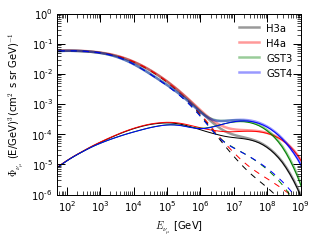

In [23]:
for pref, lab in [('numu_',r'\nu_\mu'), 
#                   ('mu_',r'\mu'), 
#                   ('nue_',r'\nu_e')
                 ]:
    plt.figure(figsize=(4.5, 3.5))
    for (flux, p_sname, p_name), col in zip(p_spectrum_flux,['k','r','g','b']):
        
        plt.loglog(e_grid, flux[pref + 'total'], color=col, ls='-', lw=2.5,
                  label=p_sname, alpha=0.4)
        plt.loglog(e_grid, flux[pref + 'conv'], color=col, ls='--', lw=1,
                   label='_nolabel_')
        plt.loglog(e_grid, flux[pref + 'pr'], color=col,ls='-', lw=1, 
                   label='_nolabel_')
    plt.xlim(50,1e9)
    plt.ylim(1e-6,1)
    plt.xlabel(r"$E_{{{0}}}$ [GeV]".format(lab))
    plt.ylabel(r"$\Phi_{" + lab + "}$ (E/GeV)$^{" + str(mag) +" }$" + 
               "(cm$^{2}$ s sr GeV)$^{-1}$")
    plt.legend(loc='upper right')
    plt.tight_layout()
    save(pref + 'flux')

Save as in ASCII file for other types of processing
---------------------------------------------------

In [ ]:
np.savetxt(open(os.path.join(desktop, 'my_flux_calculation.txt'),'w'),
zip(e_grid, 
    flux['mu_conv'],flux['mu_pr'],flux['mu_total'],
    flux['numu_conv'],flux['numu_pr'],flux['numu_total'],
    flux['nue_conv'],flux['nue_pr'],flux['nue_total'],
    flux['nutau_pr']),
fmt='%6.5E',
header=('lepton flux scaled with E**{0}. Order (E, mu_conv, mu_pr, mu_total, ' +
        'numu_conv, numu_pr, numu_total, nue_conv, nue_pr, nue_total, ' +
        'nutau_pr').format(mag)
)

In [15]:
egrid = mceq_run.e_grid
iam_str = mceq_run.iamodel_name
plotloc = os.path.join(os.path.expanduser("~"),'Google Drive/Plots/plots_new_sibyll/ICRC2015')

def make_naked(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.tick_left()
    
def save(plotname):
    plt.savefig(os.path.join(plotloc,plotname + '.pdf'))
    
def pickle_data(obj, fname):
    import cPickle as pickle
    pickle.dump(obj,open(os.path.join(plotloc,fname + '.pic'),'wb'),protocol=-1)

def unpickle_data(fname):
    import cPickle as pickle
    return pickle.load(open(os.path.join(plotloc,fname + '.pic'),'rb'))